In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from torchvision.models.vgg import VGG
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import scipy.io as spio

%matplotlib inline

In [2]:
class FCN8sScaledBN(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        # x4 and x3 are scaled by the factor of 0.01 and 0.0001 respectively
        score = self.relu(self.bn1(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4 * 0.01                         # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.bn2(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3 * 0.0001                       # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.relu(self.bn3(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.relu(self.bn4(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.relu(self.bn5(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

class FCN8sScaledOG(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, n_class, kernel_size=4, stride=2, padding=1)
        self.conv_x4 = nn.Conv2d(512, n_class, kernel_size=1, stride=1, padding=0)
        self.bn1     = nn.BatchNorm2d(n_class)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, padding=1)
        self.bn2     = nn.BatchNorm2d(n_class)
        self.conv_x3 = nn.Conv2d(256, n_class, kernel_size=1, stride=1, padding=0)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride=8, padding=4)
        self.bn3     = nn.BatchNorm2d(n_class)
        # self.bn3     = nn.BatchNorm2d(128)
        # self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn4     = nn.BatchNorm2d(64)
        # self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # self.bn5     = nn.BatchNorm2d(32)
        # self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        # x4 and x3 are scaled by the factor of 0.01 and 0.0001 respectively
        score = self.relu(self.deconv1(x5))
        score = self.bn1(score + self.conv_x4(x4 * 0.01))
        score = self.relu(self.deconv2(score))
        score = self.bn2(score + self.conv_x3(x3 * 0.0001))
        score = self.bn3(self.relu(self.deconv3(score)))
        
        # score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        # score = self.bn1(score + x4 * 0.01)               # element-wise add, size=(N, 512, x.H/16, x.W/16)
        # score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        # score = self.bn2(score + x3 * 0.0001)             # element-wise add, size=(N, 256, x.H/8, x.W/8)
        # score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        # score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        # score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        # score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [3]:
class FCN8s_bilinear(nn.Module):
    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(512, 256, kernel_size=1, padding=0, stride=1)
        self.conv2 = nn.Conv2d(256, 64, kernel_size=1, padding=0, stride=1)
        self.classifier = nn.Conv2d(64, n_class, kernel_size=1, padding=0, stride=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        # x4 and x3 are scaled by the factor of 0.01 and 0.0001 respectively
        score = nn.functional.interpolate(x5, scale_factor=2, mode='bilinear', align_corners=True)
        score += x4 * 0.01
        score = nn.functional.interpolate(score, scale_factor=2, mode='bilinear', align_corners=True)
        score = self.relu(self.conv1(score))
        score += x3 * 0.0001
        score = nn.functional.interpolate(score, scale_factor=8, mode='bilinear', align_corners=True)
        score = self.relu(self.conv2(score))

        score = self.classifier(score)

        # size=(N, n_class, x.H/1, x.W/1)
        return score

In [4]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False, batch_norm=False):
        super().__init__(make_layers(cfg[model], batch_norm=batch_norm))
        self.ranges = ranges
        self.model_urls = {
            'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
            'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
        }
        if batch_norm:
            self.model = 'vgg16_bn'
        else:
            self.model = 'vgg16'

        if pretrained:
            #exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
            self.load_state_dict(model_zoo.load_url(self.model_urls[self.model]))

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges[self.model])):
            for layer in range(self.ranges[self.model][idx][0], self.ranges[self.model][idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg16_bn': ((0, 7), (7, 14), (14, 24), (24, 34), (34, 44)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [5]:
class CenterCrop():
    """
    Crops the center of the image and its dense labels in a sample.
    Note that PIL Image instances are casted to numpy ndarrays in this step.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        img, target = sample
        # convert PIL Image to numpy.ndarray
        img = np.array(img)
        target = np.array(target)
        new_h, new_w = self.output_size
        
        # zero-pad if the width or height is less than the output_size
        if img.shape[0] < new_h:
            # zero-pad vertically
            pad_width = new_h - img.shape[0]
            up_pad = pad_width // 2
            bottom_pad = pad_width - up_pad
            img = np.pad(img, ((up_pad, bottom_pad), (0, 0), (0, 0)), 'constant', constant_values=(0, 0))
            target = np.pad(target, ((up_pad, bottom_pad), (0, 0)), 'constant', constant_values=(0, 0))
            
        if img.shape[1] < new_w:
            # zero-pad horizontally
            pad_width = new_w - img.shape[1]
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            img = np.pad(img, ((0, 0), (left_pad, right_pad), (0, 0)), 'constant', constant_values=(0, 0))
            target = np.pad(target, ((0, 0), (left_pad, right_pad)), 'constant', constant_values=(0, 0))

            
        h, w = img.shape[:2]
        
        top = (h - new_h) // 2
        left = (w - new_w) // 2
        
        img = img[top: top + new_h, left: left + new_w]
        target = target[top: top + new_h, left: left + new_w]
        assert img.shape[:2] == target.shape[:2]
        
        return img, target

In [6]:
def inference_dense_label(model, base_path, img_name, center_crop=(512, 512)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    voc_colors = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

    voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                   'diningtable', 'dog', 'horse', 'motorbike', 'person',
                   'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
    
    img_path = os.path.join(base_path + 'img', img_name + '.jpg')
    gt_path = os.path.join(base_path + 'cls', img_name + '.mat')
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(voc_colors):
        ind2color[ind] = (color, voc_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)
    
    gt_mat = spio.loadmat(gt_path, mat_dtype=True, squeeze_me=True, struct_as_record=False)
    gt_mat = gt_mat['GTcls'].Segmentation
    
    
    if center_crop:
        crop = CenterCrop(center_crop)
        img, gt_mat = crop((img, gt_mat))
        
    ax1.set_title('original image')
    ax1.imshow(img)
    
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=voc_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(gt_mat)
    
    img = np.transpose(img, [2, 0, 1])
    img = torch.from_numpy(img).to(torch.float32)
    img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = torch.unsqueeze(img, dim=0)
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1)
    
    pred = torch.squeeze(pred, dim=0)
    
    
    pred = pred.numpy()
    height, width = pred.shape
    colored_pred = np.zeros((height, width, 3), dtype=np.int32)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
    
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)

In [7]:
def visualize_inference(model, base_path, img_name, center_crop=(512, 512)):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    - center_crop: whether crop to certain height, width for better visualization
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    voc_colors = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

    voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                   'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                   'diningtable', 'dog', 'horse', 'motorbike', 'person',
                   'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
    
    img_path = os.path.join(base_path + 'img', img_name + '.jpg')
    gt_path = os.path.join(base_path + 'cls', img_name + '.mat')
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(voc_colors):
        ind2color[ind] = (color, voc_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
        
    img = Image.open(img_path).convert('RGB')
    img = np.array(img)
    gt_mat = spio.loadmat(gt_path, mat_dtype=True, squeeze_me=True, struct_as_record=False)
    gt_mat = gt_mat['GTcls'].Segmentation
    
    
    if center_crop:
        crop = CenterCrop(center_crop)
        img, gt_mat = crop((img, gt_mat))
    
    ax1.set_title('original image')
    ax1.imshow(img)
    
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=voc_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(gt_mat)
    
    img = np.transpose(img, [2, 0, 1])
    img = torch.from_numpy(img).to(torch.float32)
    img = torch.div(img, 255)
    img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # make img a 4-dimension tensor NCHW, N == 1
    img = torch.unsqueeze(img, dim=0)

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = torch.argmax(output, dim=1)
    
    # squeeze the dense label back to a 3-dimension tensor, CHW
    pred = torch.squeeze(pred, dim=0)
    
    pred = pred.numpy()
    height, width = pred.shape
    colored_pred = np.zeros((height, width, 3), dtype=np.int32)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
    
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)

# Augmented 224 * 224

In [8]:
model_state_dict_path = 'scores/FCN8s-BN-Aug/trained_model.pt'
vgg_model = VGGNet(pretrained=False, requires_grad=False, model='vgg16', batch_norm=True)
fcn_scaled = FCN8sScaledOG(pretrained_net=vgg_model, n_class=21)
fcn_scaled.load_state_dict(torch.load(model_state_dict_path, map_location='cpu'))

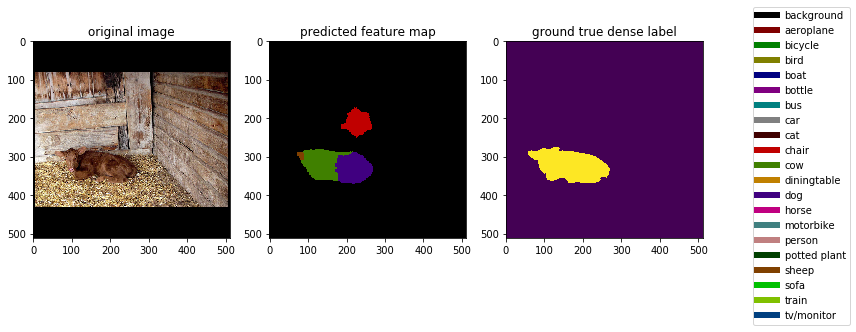

In [9]:
base_path = 'VOCAug/dataset/'
inference_dense_label(fcn_scaled, base_path, '2008_000073')

# Augmented 512 * 512

In [12]:
model_512_state_dict_path = '../scores/FCN8s-Aug-512-ScaledBN-SWP/trained_model.pt'
vgg_512 = VGGNet(pretrained=False, requires_grad=False, model='vgg16', batch_norm=True)
fcn_scaled_512_bn_swp = FCN8sScaledBN(pretrained_net=vgg_512, n_class=21)
fcn_scaled_512_bn_swp.load_state_dict(torch.load(model_512_state_dict_path, map_location='cpu'))

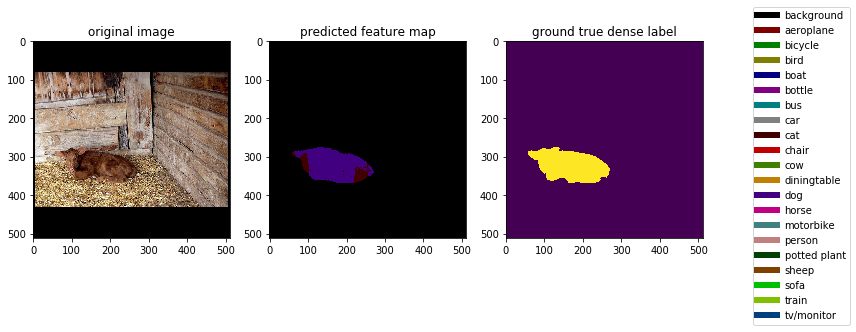

In [13]:
visualize_inference(fcn_scaled_512_bn_swp, base_path, '2008_000073')